In [ ]:
!pip install -q shap accelerate bitsandbytes peft transformers torch numpy==2.0 pandas finance-datareader transformers-interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import login
login()

In [ ]:
import FinanceDataReader as fdr
from datetime import datetime, timedelta

# 날짜 범위 설정
today = datetime.today()
start_date = (today - timedelta(days=14)).strftime('%Y-%m-%d')

# 코스피 시가총액 상위 3개 종목 코드와 이름 (2024~2025 기준)
top3_stocks = {
    "005930": "삼성전자",
    "000660": "SK하이닉스",
    "373220": "LG에너지솔루션"
}

# 프롬프트 리스트 초기화
prompt_list = []

today = datetime.today()
tomorrow = today + timedelta(days=1)
start_date = (today - timedelta(days=14)).strftime('%Y-%m-%d')

# 각 종목에 대해 반복 처리
for code, name in top3_stocks.items():
    df = fdr.DataReader(code, start=start_date)
    df['Change'] = df['Close'].pct_change().fillna(0) * 100
    last_10 = df.tail(10)

    # context 문자열 생성
    context = "\n".join([
        f"{idx.strftime('%Y-%m-%d')}, {int(row['Open'])}, {int(row['High'])}, {int(row['Low'])}, "
        f"{int(row['Close'])}, {int(row['Volume'])}, {row['Change']:.2f}"
        for idx, row in last_10.iterrows()
    ])

    # 프롬프트 생성
    prompt = (
        f"Using the context below, estimate the rate of change in the closing price of {name} on {tomorrow.strftime('%Y-%m-%d')}.\n"
        "Return the expected value of change as a decimal.\n\n"
        "Context: date, open, high, low, close, volume, change.\n"
        f"{context}\n\nAnswer:"
    )

    prompt_list.append(prompt)

# 출력
for i, p in enumerate(prompt_list, 1):
    print(f"\n--- Prompt {i} ---\n{p}")


--- Prompt 1 ---
Using the context below, estimate the rate of change in the closing price of 삼성전자 on 2025-06-11.
Return the expected value of change as a decimal.

Context: date, open, high, low, close, volume, change.
2025-05-27, 54200, 54500, 53800, 53900, 13439520, 0.00
2025-05-28, 54300, 56100, 54200, 55900, 17516283, 3.71
2025-05-29, 56200, 56400, 55600, 56100, 12936810, 0.36
2025-05-30, 56200, 57200, 55800, 56200, 26219683, 0.18
2025-06-02, 56300, 57300, 56200, 56800, 12870515, 1.07
2025-06-04, 57200, 57900, 56800, 57800, 19649983, 1.76
2025-06-05, 58100, 59900, 57900, 59100, 23266027, 2.25
2025-06-09, 60400, 60400, 59500, 59800, 19609659, 1.18
2025-06-10, 60000, 60100, 58800, 59200, 15246549, -1.00

Answer:

--- Prompt 2 ---
Using the context below, estimate the rate of change in the closing price of SK하이닉스 on 2025-06-11.
Return the expected value of change as a decimal.

Context: date, open, high, low, close, volume, change.
2025-05-27, 200500, 203500, 200000, 202500, 1424916

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# 1. 모델 및 토크나이저 불러오기
base_model = AutoModelForCausalLM.from_pretrained("capston-team-5/finma-7b-4bit-quantized", device_map="auto")
model = PeftModel.from_pretrained(base_model, "capston-team-5/finma-7b-lora-regression-v2")
tokenizer = AutoTokenizer.from_pretrained("capston-team-5/finma-7b-lora-regression-v2")

model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['pad_token_id']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['pad_token_id']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/873 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/320M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight', 'base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight', 'base_model.model.model.layers.0.mlp.gate_proj.lora_B.default.weight', 'base_model.model.model.layers.0.mlp.up_proj.lora_A.default.weight', 'base_model.model.model.layers.0.mlp.up_proj.lora_B.default.we

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
         

In [ ]:
inputs = tokenizer(prompt_list[2], return_tensors="pt").to(model.device)

# 모델 추론
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=32,
        temperature=0.7,
        do_sample=False  # greedy decoding
    )

# 출력 디코딩
decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

# 결과 출력
print("\n🧠 Model Output:\n", decoded_output)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



🧠 Model Output:
 Using the context below, estimate the rate of change in the closing price of LG에너지솔루션 on 2025-06-11.
Return the expected value of change as a decimal.

Context: date, open, high, low, close, volume, change.
2025-05-27, 275500, 276500, 268500, 272500, 149335, 0.00
2025-05-28, 276500, 290000, 272500, 289000, 395192, 6.06
2025-05-29, 289000, 291000, 283000, 288000, 189663, -0.35
2025-05-30, 286000, 290000, 283500, 286000, 224384, -0.69
2025-06-02, 290500, 291500, 281500, 284500, 174819, -0.52
2025-06-04, 288000, 293000, 286000, 288500, 214348, 1.41
2025-06-05, 287500, 295000, 284500, 291000, 207656, 0.87
2025-06-09, 291500, 291500, 280500, 285000, 297462, -2.06
2025-06-10, 286500, 292000, 285000, 288500, 213404, 1.23

Answer: -0.0123


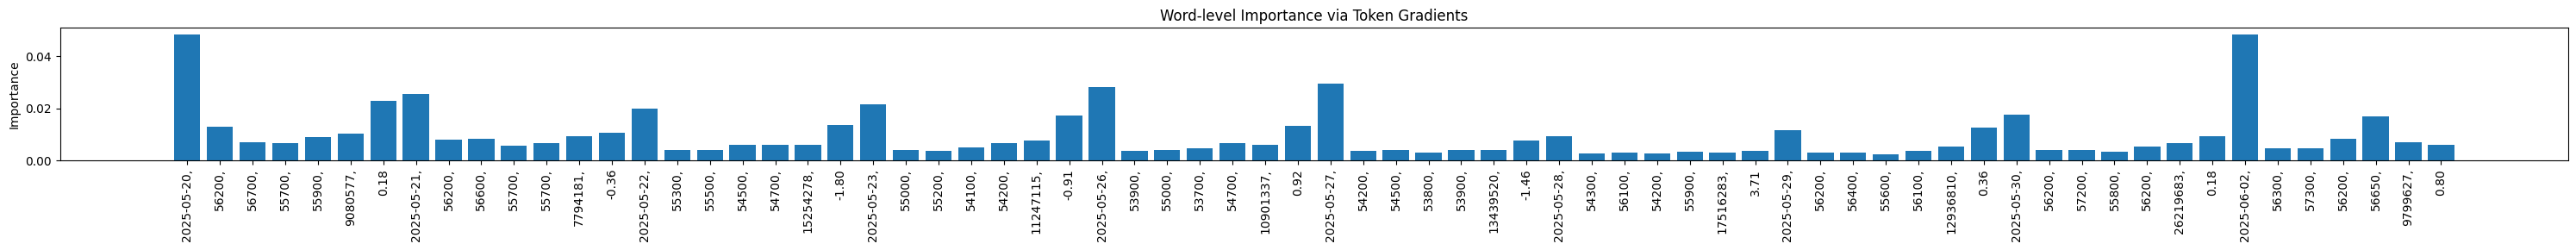

In [ ]:
import matplotlib.pyplot as plt

text = prompt_list[0]
input_ids = tokenizer(text, return_tensors="pt")["input_ids"].cuda()

# ✅ LoRA + LLaMA 구조의 임베딩 접근 (3단계 중첩)
inputs_embeds = model.base_model.model.model.embed_tokens(input_ids)
inputs_embeds.requires_grad_()

# Forward + Backward
outputs = model(inputs_embeds=inputs_embeds, labels=input_ids)
loss = outputs.loss
loss.backward()

# Gradient 중요도 계산
grads = inputs_embeds.grad.abs().sum(dim=-1).squeeze().cpu().numpy()
grads /= grads.sum()

# 1. tokenizer에서 얻은 토큰
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
tokens = [t.replace('▁', '▁') for t in tokens]  # ensure consistent marker

# 2. 단어 단위로 묶기
words = []
current_word = ""
word_indices = []  # 각 단어에 해당하는 토큰 인덱스들 저장
current_indices = []

for i, tok in enumerate(tokens):
    # 🔻 줄바꿈 토큰은 건너뛰고 무시
    if tok in ["<0x0A>", "\\n", "\n"] or re.fullmatch(r"<0x0A>", tok):
        # 현재 단어 저장
        if current_word:
            words.append(current_word)
            word_indices.append(current_indices)
            current_word = ""
            current_indices = []
        continue  # 줄바꿈 자체는 단어로 넣지 않음

    elif tok.startswith('▁'):  # 새로운 단어 시작
        if current_word:
            words.append(current_word)
            word_indices.append(current_indices)
        current_word = tok[1:]  # '▁삼' -> '삼'
        current_indices = [i]

    else:  # 현재 단어 이어 붙이기
        current_word += tok
        current_indices.append(i)

# 마지막 단어 처리
if current_word:
    words.append(current_word)
    word_indices.append(current_indices)

# 단어에서 깨진 문자 제거
import re
words = [re.sub(r'<0x[A-Fa-f0-9]+>', '', w) for w in words]
words = [re.sub(r'\\n', '', w) for w in words]
words = [w.strip() for w in words if w.strip() != '']

# 3. 단어별 중요도 계산
word_scores = []
for indices in word_indices:
    score = sum(grads[i] for i in indices)
    word_scores.append(score)

words = words[35:len(words)-1]
word_scores = word_scores[35:len(word_scores)-1]

def Make_Token_List(words, words_scores):
    temp = words.copy()
    temp_score = word_scores.copy()
    for i in range(len(temp)):
        temp[i] = temp[i][:len(temp[i]) - 1]
    # 1) 날짜 별로
    token_list = []
    for i in range(0, len(temp), 7):
        token_list.append(temp[i:i + 7])
    token_score_list = []
    for i in range(0, len(temp), 7):
        token_score_list.append(temp_score[i:i + 7])

    return token_list, token_score_list


token_list, token_score_list = Make_Token_List(words, word_scores)

# token_list : 2차원 배열로 날짜 별로 token 값 저장.
# token_score_list : 2차원 배열로 단어 token들의 importance 값.

# 위의 token_list와 token_score_list를 front로 넘겨주시면 될 것 같습니다 !

# --------------------------------------------------------------------------


# 4. 시각화
plt.figure(figsize=(30, 3))
plt.bar(range(len(words)), word_scores)
plt.xticks(range(len(words)), words, rotation=90)
plt.title("Word-level Importance via Token Gradients")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()